In [26]:
import warnings
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

warnings.filterwarnings('ignore')

In [27]:
import wandb

wandb.login(key='71321e5b443291086842a123a16fdf4d0991f10e')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [28]:
from datasets import load_dataset

cppe = load_dataset('rishitdagli/cppe-5')

if "validation" not in cppe:
    split = cppe['train'].train_test_split(0.15,seed=42)
    cppe['train'] = split['train']
    cppe['validation'] = split['test']

In [29]:
cppe['train'][0]

{'image_id': 9,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200>,
 'width': 200,
 'height': 200,
 'objects': {'id': [56, 57, 58],
  'area': [2160, 306, 13593],
  'bbox': [[146.0, 86.0, 54.0, 40.0],
   [33.0, 22.0, 18.0, 17.0],
   [2.0, 3.0, 69.0, 197.0]],
  'category': [4, 4, 0]}}

In [30]:
import numpy as np
import os
from PIL import Image,ImageDraw

image = cppe['train'][0]['image']
annotations = cppe['train'][0]['objects']
draw = ImageDraw.Draw(image)

In [31]:
categories = cppe['train'].features['objects'].feature['category'].names
categories

['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask']

In [32]:
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

width = cppe['train'][0]['width']
height = cppe['train'][0]['height']

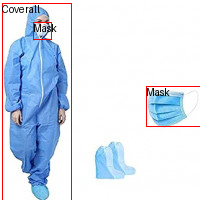

In [33]:
for i in range(len(annotations['id'])):
    box = annotations['bbox'][i]
    class_idx = annotations['category'][i]
    x,y,w,h = tuple(box)
    
    if max(box) > 1.0:
        x1,y1 = int(x),int(y)
        x2,y2 = int(x+w),int(y+h)
    else:
        x1 = int(x*width)
        y1 = int(y*height)
        x2 = int((x+w) * width)
        y2 = int((y+h) * height)
    draw.rectangle((x,y,x+w,y+h),outline='red',width=1)
    draw.text((x, y), id2label[class_idx], fill="black")

image
        

In [34]:
from transformers import AutoImageProcessor

MAX_SIZE = 480
MODEL_NAME = "microsoft/conditional-detr-resnet-50"

processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height":MAX_SIZE,"max_width":MAX_SIZE},
    do_pad=True,
    pad_size={'height':MAX_SIZE, 'width':MAX_SIZE},
)

In [36]:
def format_image_annotations_as_coco(image_id,categories,areas,bboxes):
    annotations = []
    for category,area, bbox in zip(categories,areas,bboxes):
        formatted_annotation = {
            'image_id': image_id,
            'category_id': category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox)
        }
        annotations.append(formatted_annotation)
    
    return {
        "image_id": image_id,
        "annotations": annotations,
    }

In [37]:
def augment_and_transform_batch(
    examples, transform, image_processor, return_pixel_mask=False
):
    images = []
    annotations = []
    for image_id, image, objects in zip(
        examples["image_id"], examples["image"], examples["objects"]
    ):
        image = np.array(image.convert("RGB"))

        output = transform(
            image=image, bboxes=objects["bbox"], category=objects["category"]
        )
        images.append(output["image"])

        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    result = image_processor(
        images=images, annotations=annotations, return_tensors="pt"
    )

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

In [47]:
import albumentations as A

train_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1)
    ],
    bbox_params=A.BboxParams(format='coco',label_fields=['category'],clip=True,min_area=25,filter_invalid_bboxes=True)
)

test_transform = A.Compose(
    [
        A.NoOp()
    ],
    bbox_params=A.BboxParams(format='coco',label_fields=['category'],clip=True)
)

In [49]:
from functools import partial

train_transform_batch = partial(
    augment_and_transform_batch,
    transform=train_transform,
    image_processor=processor,
)

validation_transform_batch = partial(
    augment_and_transform_batch,
    transform=test_transform,
    image_processor=processor,
)

cppe['train'] = cppe['train'].with_transform(train_transform_batch)
cppe["test"] = cppe["test"].with_transform(validation_transform_batch)
cppe["validation"] = cppe["validation"].with_transform(validation_transform_batch)

cppe['train'][15]

{'pixel_values': tensor([[[-1.4843, -1.4843, -1.4843,  ...,  2.0092,  2.0092,  2.0092],
          [-1.4843, -1.4843, -1.4843,  ...,  2.0092,  2.0092,  2.0092],
          [-1.4672, -1.4672, -1.4672,  ...,  2.0092,  2.0092,  2.0092],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.5651, -0.5651, -0.5651,  ...,  2.3410,  2.3410,  2.3410],
          [-0.5651, -0.5651, -0.5651,  ...,  2.3410,  2.3410,  2.3410],
          [-0.5476, -0.5476, -0.5476,  ...,  2.3410,  2.3410,  2.3410],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.0267, -0.0267, -0.0267,  ...,  2.0997,  2.0997,  2.0997],
          [-

In [50]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data

In [51]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes,image_size):
    boxes = center_to_corners_format(boxes)
    height,width = image_size
    
    boxes = boxes * torch.tensor([[width,height,width,height]])
    
    return boxes

In [66]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision

@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results,image_processor,threshold=0.0,id2label=None):
    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    for batch in targets:
        batch_image_sizes = torch.tensor(np.array([x['orig_size'] for x in batch]), dtype=torch.int64)
        image_sizes.append(batch_image_sizes)

        for image_target in batch:
            boxes = torch.tensor(image_target['boxes'])
            boxes = convert_bbox_yolo_to_pascal(boxes,image_target['orig_size'])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append(
                {
                    "boxes": boxes,
                    "labels": labels,
                }
            )

    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1],batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits),pred_boxes=torch.tensor(batch_boxes))

        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )

        post_processed_predictions.extend(post_processed_output)

    metric = MeanAveragePrecision(box_format="xyxy",class_metrics=True)
    metric.update(post_processed_predictions,post_processed_targets)
    metrics = metric.compute()

    classes = metrics.pop('classes')
    map_per_class = metrics.pop('map_per_class')
    mar_100_per_class = metrics.pop('mar_100_per_class')

    for class_id, class_map,class_mar in zip(classes,map_per_class,mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f'mAP_{class_name}'] = class_map
        metrics[f'mAR_100_{class_name}'] = class_mar

    metrics = {
        k : round(v.item(),4) for k,v in metrics.items()
    }

    return metrics

eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=processor, id2label=id2label, threshold=0.0
)

In [53]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="cppe_finetuned_microsoft_detr",
    num_train_epochs=30,
    fp16=False,
    per_device_train_batch_size=8,
    dataloader_num_workers=4,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    push_to_hub=True,
)

In [44]:
from huggingface_hub import login

login()

In [67]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cppe['train'],
    eval_dataset=cppe['validation'],
    processing_class=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Coverall,Mar 100 Coverall,Map Face Shield,Mar 100 Face Shield,Map Gloves,Mar 100 Gloves,Map Goggles,Mar 100 Goggles,Map Mask,Mar 100 Mask
1,No log,1.293128,0.155500,0.324300,0.131400,0.055800,0.163200,0.166900,0.193700,0.367300,0.401800,0.195000,0.365000,0.463300,0.454800,0.675600,0.036300,0.290300,0.070100,0.339300,0.044200,0.306300,0.172000,0.397400
2,No log,1.260982,0.190800,0.398600,0.151700,0.087900,0.174300,0.219200,0.227600,0.402300,0.437800,0.214200,0.380100,0.535600,0.508900,0.686100,0.054900,0.340300,0.091500,0.376400,0.094900,0.350000,0.204000,0.436000
3,No log,1.243739,0.185700,0.385000,0.150100,0.068500,0.170300,0.228200,0.221500,0.381800,0.414200,0.244100,0.347600,0.490800,0.513300,0.690600,0.058400,0.314500,0.086900,0.334800,0.062700,0.310400,0.207300,0.420600
4,No log,1.233325,0.185600,0.382300,0.158400,0.064500,0.189100,0.245800,0.233400,0.401600,0.435000,0.228900,0.390400,0.531800,0.480000,0.671700,0.051600,0.359700,0.092600,0.344900,0.092500,0.402100,0.211100,0.396800
5,1.262800,1.188837,0.216400,0.441100,0.189600,0.094500,0.217600,0.280300,0.255300,0.426900,0.458000,0.295300,0.416200,0.539900,0.517200,0.694400,0.061500,0.403200,0.129100,0.390400,0.107500,0.366700,0.266600,0.435400
6,1.262800,1.208126,0.217600,0.439500,0.192900,0.102400,0.207200,0.282100,0.245900,0.411200,0.442200,0.246200,0.391900,0.524400,0.546100,0.669400,0.092600,0.385500,0.100200,0.325300,0.106100,0.412500,0.243100,0.418500
7,1.262800,1.181715,0.221100,0.448700,0.180800,0.115700,0.220000,0.285300,0.267200,0.429100,0.457100,0.293300,0.404400,0.538400,0.556200,0.698300,0.114000,0.388700,0.120200,0.363500,0.076800,0.387500,0.238400,0.447600
8,1.262800,1.147874,0.236600,0.470700,0.200000,0.095000,0.223400,0.333800,0.281200,0.440700,0.461400,0.271600,0.409800,0.543600,0.562600,0.702200,0.087500,0.404800,0.145900,0.365700,0.123500,0.410400,0.263200,0.423800
9,1.262800,1.154875,0.236800,0.489000,0.193400,0.116900,0.227500,0.321700,0.279800,0.432400,0.457500,0.251200,0.413900,0.535500,0.553700,0.685600,0.104400,0.400000,0.152800,0.350600,0.126800,0.418700,0.246500,0.432800
10,1.128800,1.130465,0.235900,0.487400,0.197400,0.085500,0.224800,0.319600,0.276800,0.455400,0.479300,0.287100,0.426800,0.571900,0.563000,0.708300,0.090300,0.430600,0.150900,0.368000,0.097800,0.454200,0.277700,0.435400


TrainOutput(global_step=3210, training_loss=0.9934954396660826, metrics={'train_runtime': 1316.2561, 'train_samples_per_second': 19.373, 'train_steps_per_second': 2.439, 'total_flos': 4.5811929694464e+18, 'train_loss': 0.9934954396660826, 'epoch': 30.0})